### Basic usage of the `Hypersolver` API

We showcase the `torchdyn` API for [hypersolvers](https://arxiv.org/pdf/2007.09601.pdf). Hypersolvers, or hybrid ODE solvers equipped with a neural network to approximate residuals, are seamlessly integrated into the `odeint` API. A major design of the API is exactly preserving a persistent state for the solver, which in the case of standard ODE solvers contains the Tableau. For hypersolvers, the state also contains their hypernetwork parameters.

In [1]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

%load_ext autoreload
%autoreload 2

In [2]:
class Lorenz(nn.Module):
    def __init__(self):
        super().__init__()
        self.p = nn.Linear(1,1)
    
    def forward(self, t, x):
        x1, x2, x3 = x[...,:1], x[...,1:2], x[...,2:]
        dx1 = 10 * (x2 - x1)
        dx2 = x1 * (28 - x3) - x2
        dx3 = x1 * x2 - 8/3 * x3
        return torch.cat([dx1, dx2, dx3], -1)

In [3]:
x0 = torch.randn(512, 3) + 15 # solve 512 IVPs in parallel!
t_span = torch.linspace(0, 5, 4000)
sys = Lorenz()
t_eval, sol_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-8, rtol=1e-8)

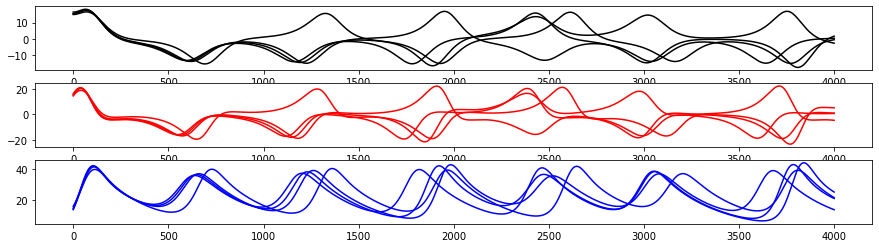

In [4]:
fig = plt.figure(figsize=(15, 4))
axs = fig.subplots(3,1)
axs[0].plot(sol_gt[:,:4,0], c='black'); axs[1].plot(sol_gt[:,:4,1], c='r'); axs[2].plot(sol_gt[:,:4,2], c='b');

#### Can we speed up simulation?

In [5]:
class VanillaHyperNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    def forward(self, t, x):
        return self.net(x)

In [6]:
net = nn.Sequential(nn.Linear(3, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 3))
hypersolver = HyperEuler(VanillaHyperNet(net))
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver, atol=1e-5, rtol=1e-5)
sol = sol.detach()

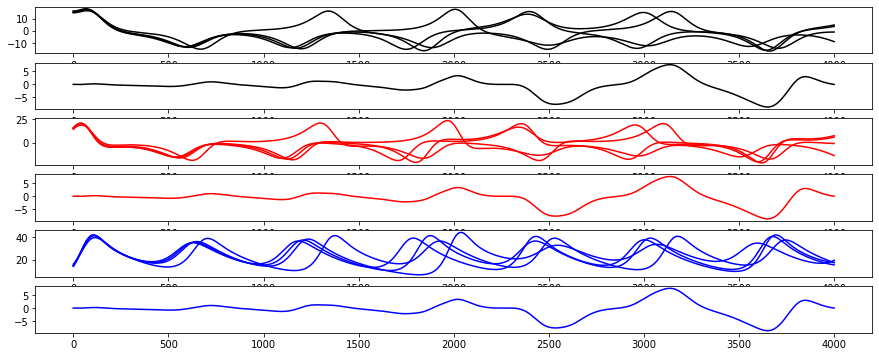

In [7]:
fig = plt.figure(figsize=(15, 6))
axs = fig.subplots(6,1)
axs[0].plot(sol[:,:4,0], c='black'); axs[2].plot(sol[:,:4,1], c='r'); axs[4].plot(sol[:,:4,2], c='b');
# The error accumulates as Euler is not enough. 
# Here are the errors (mean across batches of initial conditions)
axs[1].plot((sol-sol_gt)[:,:4,0].mean(1), c='black')
axs[3].plot((sol-sol_gt)[:,:4,0].mean(1), c='r')
axs[5].plot((sol-sol_gt)[:,:4,0].mean(1), c='b');

#### Train the Hypersolver

We can train our hypersolver on residuals between ground-truth solution and base solver (in this case Euler)

In [8]:
base_solver = Euler()
X = sol_gt[:-1].reshape(-1, 3)
X_next_gt = sol_gt[1:].reshape(-1, 3)
# step forward (fixed-step, time-invariant system hence any `t` as first argument is fine) with base solver
dt = t_span[1] - t_span[0]
_, _, X_next = base_solver.step(sys, X, 0., dt) # step returns a Tuple (k1, berr, sol). The first two values are used internally
# within `odeint`
residuals = (X_next_gt - X_next) / dt**2

In [13]:
device = torch.device('cuda:0')
model = nn.DataParallel(hypersolver, device_ids=[0,1]) # feel free to change here according to your setup and GPU available.
model = model.to(device)
X = X.to(device)
residuals = residuals.to(device)

In [ ]:
opt = torch.optim.Adadelta(model.parameters(), lr=3e-3)
STEPS = 80000
loss_func = nn.MSELoss()
hypernet = model.module.hypernet
for k in range(STEPS):
    residuals_hypersolver = hypernet(0., X)
    loss = loss_func(residuals, residuals_hypersolver)
    print(f'Step: {k}, Residual loss: {loss:.3f}', end='\r')
    loss.backward(); opt.step(); opt.zero_grad()

In [ ]:
t0 = time.time()
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver, atol=1e-5, rtol=1e-5)
sol = sol.detach()
timing = time.time() - t0; print(timing)

t0 = time.time()
t_eval, sol_other = odeint(sys, x0, t_span, solver='tsit5', atol=1e-4, rtol=1e-4)
sol = sol.detach()
timing = time.time() - t0; print(timing)

# roughly 3 times faster than a lower tol tsit5. How does the accuracy compare?

In [ ]:
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

In [ ]:
error_hyper = smape(sol_gt, sol).mean(1)
error_other = smape(sol_gt, sol_other).mean(1)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
for i in range(4):
    for j in range(3):
        ax.plot(sol[:,i,j], c='b', alpha=0.4)
        ax.plot(sol_other[:,i,j], c='r')
        ax.plot(sol_gt[:,i,j], c='black')
        ax.legend(['HyperEuler', 'Other'])
        
ax = fig.add_subplot(1,3,2)
for i in range(4):
    ax.plot(sol[:,i,0], sol[:,i,2], c='blue')
    ax.plot(sol_other[:,i,0], sol_other[:,i,2], c='r')
    ax.plot(sol_gt[:,i,0], sol_gt[:,i,2], c='green')


ax = fig.add_subplot(1,3,3)
ax.plot(error_hyper, c='r')
ax.plot(error_other, c='black');

Great! For the curious, here are more applications of [hypersolvers to Neural ODEs](https://github.com/DiffEqML/diffeqml-research/tree/master/hypersolver). For those interested in hypersolvers usage for non-neural ODEs, here is further analysis specifically centered around [HyperEuler](https://arxiv.org/abs/2003.09573#:~:text=In%20this%20paper%2C%20we%20propose,with%20a%20large%20step%20size.) (or DeepEuler).